# IMPORTING LIBRARIES AND DATASET

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('Forecast Primary Sales.csv')

In [4]:
data.head()

,Month Year,Bill_Value
0,Apr-19,259028743.6
1,May-19,304323603.0
2,Jun-19,292830638.7
3,Jul-19,278436714.0
4,Aug-19,325491393.0


# DATA PREPROCESSING

<AxesSubplot:xlabel='Month Year'>

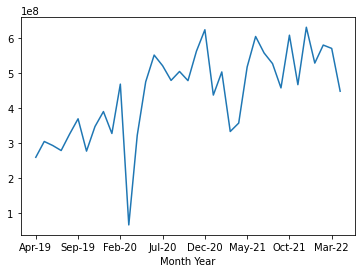

In [32]:
#INDEXING THE MONTH COLUMN
data.index = data['Month Year']
del data['Month Year']
#PLOTTING THE GRAPH
data['Bill_Value'].plot()

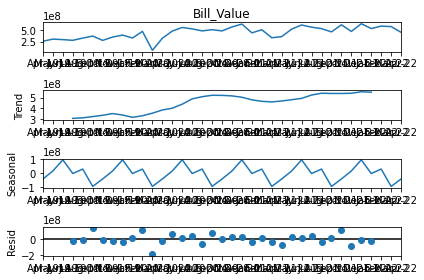

In [33]:
#We can check the trend and seasonality using the
# seasonal_decompose() method.
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(data['Bill_Value'],period=6)
decompose_result.plot();

# CHECK DATA FOR STATIONARITY

In [34]:
from statsmodels.tsa.stattools import adfuller
#p-value > 0.05: ---> not stationary
#p-value <= 0.05: --> stationary
result = adfuller(data['Bill_Value'])
#print(result)
#print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
	#print('\t%s: %.3f' % (key, value))
if result[1]>0.05:
	print('not stationary')
else:
	print("stationary")

p-value: 0.010788
stationary


In [35]:
result = adfuller(data['Bill_Value'].dropna())
#print(result)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.405035
p-value: 0.010788
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612


# ORDER OF ARIMA MODEL

In [36]:
from pmdarima import auto_arima

In [37]:
order = auto_arima(data['Bill_Value'], trace=True)
order.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1446.089, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1441.963, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1438.114, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1444.170, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1439.794, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1442.591, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1441.460, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1438.098, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1439.715, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1440.004, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1440.302, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1441.902, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.805 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   37
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -717.049
Date:                Sat, 04 Mar 2023   AIC                           1438.098
Time:                        12:54:14   BIC                           1441.265
Sample:                             0   HQIC                          1439.203
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5970      0.160     -3.742      0.000      -0.910      -0.284
sigma2       1.28e+16   4.62e-18   2.77e+33      0.000    1.28e+16    1.28e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                10.81
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -1.04
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+49. Standard errors may be unstable.
"""

# IMPORTING THE ARIMA MODEL

In [38]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [39]:
print(data.shape)
train = data.iloc[:30]
test = data.iloc[30:]
print(train.shape,test.shape)

(37, 1)
(30, 1) (7, 1)


# SARIMAX MODELLING FOR SEASONAL FACTOR AND EXOGENOUS FACTOR

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
model = SARIMAX(train, order=(0,1,1), seasonal_order=(1,1,1,6))
model = model.fit()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# PREDICTING VALUES

In [44]:
start= len(train)
end=len(train)+len(test)-1
pred = model.predict(start=start,end=end,typ='levels')
pred.index=data.index[start:end+1]
data['pred']=pred
data.tail()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Bill_Value,pred
Month Year,,
Dec-21,631343678.2,6.573947e+08
Jan-22,528736845.3,5.160696e+08
Feb-22,580343070.3,5.534803e+08
Mar-22,570737221.1,4.197373e+08
Apr-22,448207092.1,4.425064e+08


<AxesSubplot:xlabel='Month Year'>

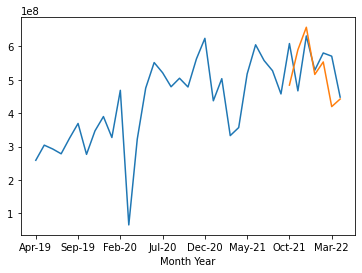

In [47]:
data['Bill_Value'].plot()
data['pred'].plot()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='Month Year'>

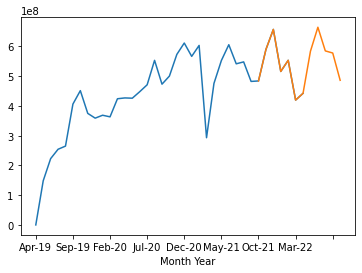

In [24]:
#predicting the projections for the next 12 months

forecast = model.forecast(steps=12)
pred.plot()
forecast.plot()

In [59]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test['Bill_Value']))
print(rmse)
mean = test['Bill_Value'].mean()

88632771.99825507


In [60]:
percentage_error = (rmse/mean)*100
print(percentage_error)

16.178693653586777


In [ ]:
no_forcast_month=12
dates=[]
billval=[]
for i in data['Month Year']:
    dates.append(i)

for i in train:
    billval.append(i)
    
for i in range(1,no_forcast_month+1):
    future_date = data['Month Year'][len(data)-1] + relativedelta(months=i)
    dates.append(future_date)

prediction= results.predict(start=int(len(data)*0.7)+1,end=len(data)+12,dynamic=True) # start int(len(dataset)*0.7)+1 end len(dataset)+12

for i in range(1,len(prediction)):
    billval.append(prediction[i])
    
t_df=pd.DataFrame({'Month':dates,'Forecasted':billval})